<a href="https://colab.research.google.com/github/andresacam/Simulaciones/blob/main/SimMC_Mantenimiento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PROCESO DE SIMULACIÓN POR METODO DE MONTECARLO PARA UNA LICITACIÓN.

Estudiamos el caso de una empresa dedicada al **mantenimiento industrial**, la cual tiene interés en presentarse a una licitación para una planta de **Refinería de Petroleo**. La propuesta técnica ya está disponible y es necesario determinar los costos del proyecto para confeccionar la oferta.

Tenemos disponible información sobre recursos y mano de obra necesaria, sin embargo el tomador de decisiones enfrenta un dilema:

   "*Ofrecer un precio muy competitivo facilita ser adjudicado pero aumenta el riesgo de perder dinero si el proyecto cuesta más, por otra parte, si ofrece un precio elevado se asegura la rentabilidad a costa de incrementar la probabilidad de ser rechazado*".

Para solucionar este problema, proponemos realizar una **simulación por método de Monte Carlo**, donde generaremos miles de combinaciones posibles para cada uno de los factores que componen los costos totales. Finalizaremos con un análisis estadístico del costo total que le facilitará el trabajo al **tomador de decisiones**.

In [26]:

from google.colab import auth
import gspread
from google.auth import default
import pandas as pd

# Autenticación
auth.authenticate_user()
creds, _ = default()

# Conectamos a Google Sheets para extraer los datos.
client = gspread.authorize(creds)

sheet_url = 'a://docs.google.com`/spreadsheets/d/1NywOqhWgan8QXJNp0wqwH0CUaiFXQbJLhl42GJn8Ibw/edit?gid=0#gid=0'  # Reemplaza con la URL de tu hoja de Google Sheets
sheet = client.open_by_url(sheet_url).sheet1  # Selecciona la primera hoja (sheet1)

# Transformamos los datos para poder realizar la Simulacion
data = sheet.get_all_records()

df = pd.DataFrame(data)

# Función para eliminar los euros y convertir los datos a numeros
def limpiar_euros(val):
    if isinstance(val, str):

        val = val.replace('€', '').replace(',', '').strip()

        try:
            return float(val)
        except ValueError:
            return val
    return val

# Aplicar la función de limpieza a todas las columnas del DataFrame
df = df.applymap(limpiar_euros)

# Mostrar el DataFrame, confirmamos que tenemos la informacion en el formato que la necesitamos.
df.head()


<ipython-input-26-ea92dbeab0cd>:34: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(limpiar_euros)


,Item,Valor_Minimo,Valor_Probable,Valor_Maximo
0,Alimento,1.012.500,1.125.000,1.237.500
1,Transporte_Op,400.0,500.0,550.0
2,Transporte_Sup,66.667,333.333,333.333
3,Alojamiento_Sup,2.555.000,3.650.000,3.832.500
4,Seguros,1.159.950,1.221.000,1.245.420


In [27]:
import numpy as np
import pandas as pd



for col in ['Valor_Minimo', 'Valor_Probable', 'Valor_Maximo']:
    if df[col].dtype != 'object':
        df[col] = df[col].astype(str)


df['Valor_Minimo'] = df['Valor_Minimo'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
df['Valor_Probable'] = df['Valor_Probable'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)
df['Valor_Maximo'] = df['Valor_Maximo'].str.replace('.', '', regex=False).str.replace(',', '.', regex=False)


df['Valor_Minimo'] = pd.to_numeric(df['Valor_Minimo'], errors='coerce')
df['Valor_Probable'] = pd.to_numeric(df['Valor_Probable'], errors='coerce')
df['Valor_Maximo'] = pd.to_numeric(df['Valor_Maximo'], errors='coerce')


df = df.dropna(subset=['Valor_Minimo', 'Valor_Probable', 'Valor_Maximo'])

#  Definimos la función para generar valores segun la distribucion PERT.
def pert_rnd(valor_minimo, valor_probable, valor_maximo, lamb=4, size=1):
    """Genera valores aleatorios según la distribución PERT."""
    delta = valor_maximo - valor_minimo
    delta[delta == 0] = 1e-6  # Reemplazamos cero por un pequeño número para evitar división por cero

    alpha = 1 + lamb * (valor_probable - valor_minimo) / delta
    beta = 1 + lamb * (valor_maximo - valor_probable) / delta

    # Generamos valores aleatorios de la distribución beta
    return np.random.beta(alpha, beta, size=size) * delta + valor_minimo

#  Función para realizar la simulación de Monte Carlo
def simulacion_montecarlo(df, iteraciones=10000):
    resultados_totales = []
    iteracion_ejemplo = 5  # Extraemos el ejemplo de la iteracion 5 para verificar el funcionamiento

    # Excluimos la primera fila (títulos) y la primera columna (clasificación)
    for i in range(iteraciones):
        # Generamos muestras aleatorias para cada fila
        muestras = pert_rnd(
            df['Valor_Minimo'].values,
            df['Valor_Probable'].values,
            df['Valor_Maximo'].values,
            lamb=4,
            size=len(df)  # Generamos una muestra por cada fila
        )

        # Acumulamos los costos simulados para cada item.
        costo_total = np.sum(muestras)
        resultados_totales.append(costo_total)

        # Mostramos los valores generados en la iteración de ejemplo
        if i == iteracion_ejemplo - 1:
            print(f"Iteración {iteracion_ejemplo}:")
            for j, valor in enumerate(muestras):
                print(f"  Costo para item {j+1}: {valor:.2f}")
            print(f"  Costo Total: {costo_total:.2f}\n")

    # Convertimos resultados a DataFrame
    resultados_df = pd.DataFrame({'Costo_Total': resultados_totales})
    return resultados_df

# Ejecutamos la simulación
resultados_df = simulacion_montecarlo(df)

# Verificamos la media del costo total
media_costo_total = resultados_df['Costo_Total'].mean()
print(f"Media del Costo Total: {media_costo_total:.2f}")

# Mostramos la estadísticas descriptivas del resultado preliminar.
print(resultados_df.describe())


Iteración 5:
  Costo para item 1: 1062374.48
  Costo para item 2: 3496283.51
  Costo para item 3: 1207868.40
  Costo para item 4: 7997980.86
  Costo para item 5: 1917816.01
  Costo para item 6: 12645853.04
  Costo para item 7: 19829451.69
  Costo Total: 48157627.98

Media del Costo Total: 44106077.82
        Costo_Total
count  1.000000e+04
mean   4.410608e+07
std    5.399257e+06
min    2.843347e+07
25%    4.058159e+07
50%    4.335271e+07
75%    4.720547e+07
max    6.897446e+07


#RESULTADOS
Ahora analizamos los resultados de la simulación, estudiando la variable costo total y realizando un grafico de probabilidad acumulada, podemos obtener información de vital importancia para el **tomador de decisiones**.

Permite identificar la probabilidad de que el costo este por debajo de un valor especifico, por ejemplo, **la probabilidad de que el costo real del proyecto sea inferior a 50 Millones es del 85%**.

Si el **tomador de decisiones** adopta una probabilidad de 95% como un intervalo confiable, entonces puede dar por hecho que la obra costara 55 Millones.

Se adjuntan adicionalmente graficos de densidad y frecuencia.



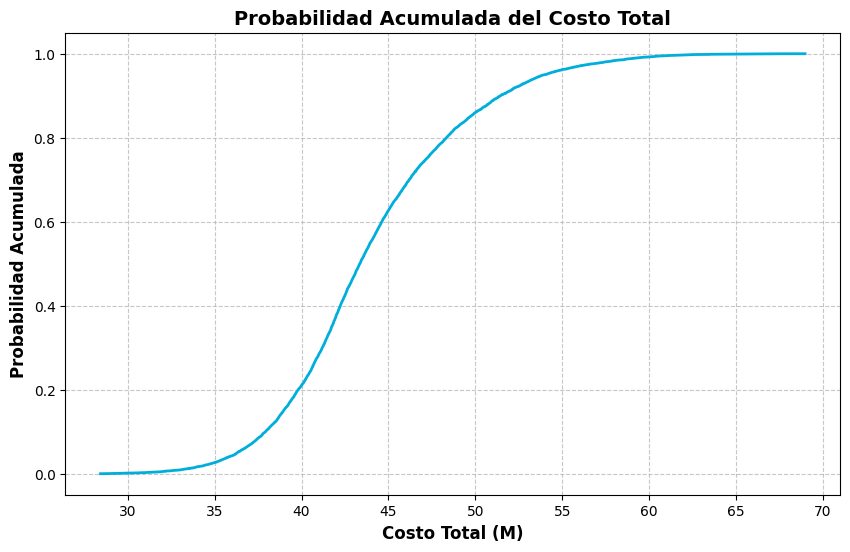

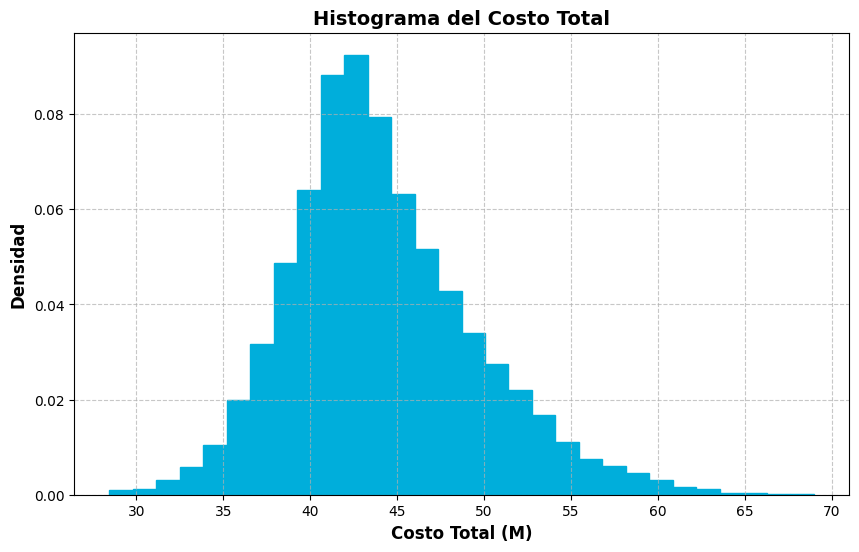

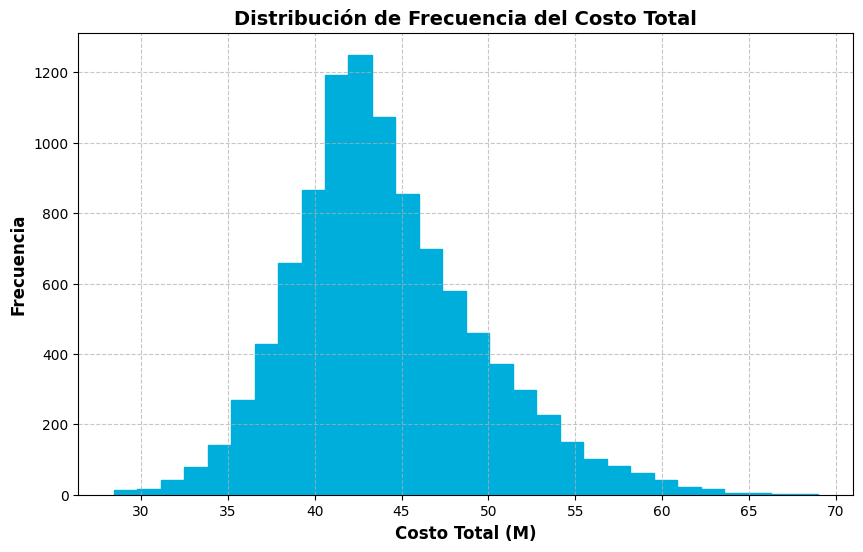

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def grafico_mcky(df, columna):



    colors = ['#00AEDB', '#00AEDB', '#00AEDB']

    # Gráfico de probabilidad acumulada
    plt.figure(figsize=(10, 6))
    plt.plot(np.sort(df[columna])/1e6, np.arange(len(df)) / len(df), color=colors[0], linewidth=2)
    plt.xlabel('Costo Total (M)', fontsize=12, fontweight='bold')
    plt.ylabel('Probabilidad Acumulada', fontsize=12, fontweight='bold')
    plt.title('Probabilidad Acumulada del Costo Total', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    # Histograma
    plt.figure(figsize=(10, 6))
    plt.hist(df[columna]/1e6, bins=30, color=colors[1], edgecolor=colors[2], density=True)
    plt.xlabel('Costo Total (M)', fontsize=12, fontweight='bold')
    plt.ylabel('Densidad', fontsize=12, fontweight='bold')
    plt.title('Histograma del Costo Total', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

    # Gráfico de distribución de frecuencia
    plt.figure(figsize=(10, 6))
    plt.hist(df[columna]/1e6, bins=30, color=colors[1], edgecolor=colors[2])
    plt.xlabel('Costo Total (M)', fontsize=12, fontweight='bold')
    plt.ylabel('Frecuencia', fontsize=12, fontweight='bold')
    plt.title('Distribución de Frecuencia del Costo Total', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()

# Llamada a la función con la columna 'Costo_Total'
grafico_mcky(resultados_df, 'Costo_Total')

Una forma de ilustrar el método, consiste en graficar la evolución del costo total segun avanzan las iteraciones. Podremos ver que el costo se concentra en un rango entre 38 Millones y 44 Millones, sin embargo existen casos donde podemos encontrar valores por encima de los 60 Millones.

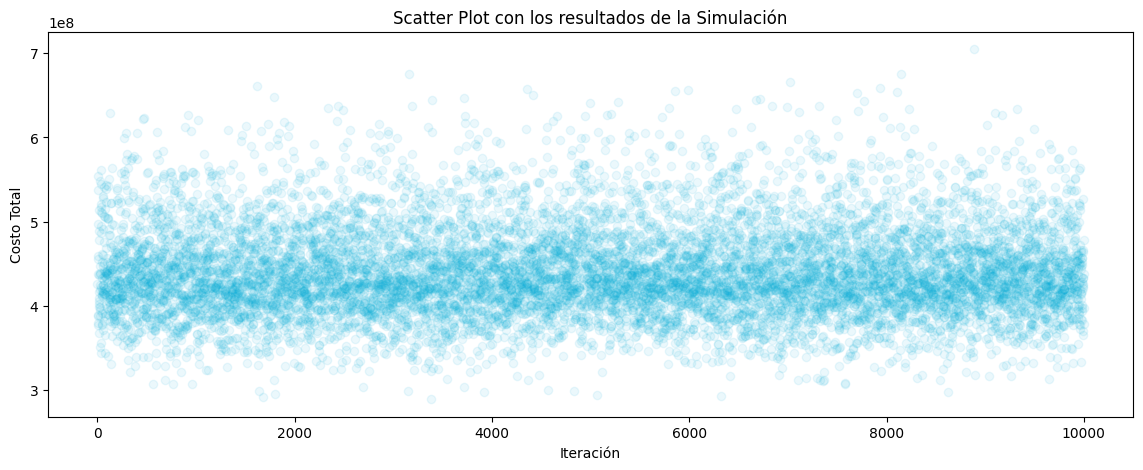

In [24]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1, len(resultados_df) + 1)
y = resultados_df['Costo_Total'].values

# Crear gráfico de dispersión con transparencia
plt.figure(figsize=(14, 5))
plt.scatter(x, y, alpha=0.08, color='#00AEDB')
plt.title("Scatter Plot con los resultados de la Simulación")
plt.xlabel("Iteración")
plt.ylabel("Costo Total")
plt.grid(False)
plt.show()

